# Imports

In [1]:
import pandas as pd
import numpy as np
import scipy as sp
pd.options.display.max_rows = 400
pd.options.display.max_columns = 400
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
from datetime import datetime
from collections import defaultdict
import pickle
import pandas as pd
import numpy as np
import scipy as sp

from epiml.loadepiml import LoadEpiml, save_search, load_search
from epiml.epimlsklearn.epimlmetrics import pu_scorer, prior_squared_error_scorer_015, brier_score_labeled_loss_scorer, \
    f1_assumed_scorer, f1_labeled_scorer, report_metrics, f1_assumed_beta10_scorer, pu_mix_assumed_f1beta10_scorer
from epiml.semisuperhelper import SemiSupervisedHelper
from epiml.epimlsklearn.pnuwrapper import PNUWrapper
from epiml.epimlsklearn.jsearchcv import JRandomSearchCV, extract_score_grid
from epiml.epimlsklearn.nestedcross import NestedCV
from epiml.epimlsklearn.frankenscorer import FrankenScorer, extract_scores_from_nested
from epiml.epimlsklearn.repeatedsampling import RepeatedRandomSubSampler

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.base import clone
from sklearn.externals.joblib import Parallel, delayed

from lime.lime_tabular import LimeTabularExplainer

In [3]:
from epiml.modeldeepdive import ModelDeepDive, create_model_6

# Load and then Train Best Model

In [4]:
path = "C:\\Data\\010317\\membership14_final_0103.txt"
print("Loading {}".format(path))
try:
    lc = LoadEpiml(path)
except FileNotFoundError:
    #This is for running on a machine not on network that can see the data
    print("File doesn't exist, generating fake data!")
    from sklearn.datasets import make_classification
    X, y = make_classification(n_samples=10000, n_features=200, n_informative=50, n_redundant=100, n_classes=2,
                               n_clusters_per_class=3, weights=[0.9], flip_y=0, hypercube=False,
                               random_state=101)

    #make this like the unlabeled problem we are solving -change most to unlabeled class == -1
    rnd_unlabeled = np.random.choice([True, False], size=len(y), replace=True, p=[0.8,0.2])
    y[rnd_unlabeled] = -1
    X = pd.DataFrame(X)
    y = pd.Series(y)
else:
    X = lc.X
    y = lc.y
print("Done loading")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=771, stratify=y)
print("Split Data: train_size {}, test_size {}".format(X_train.shape, X_test.shape))

Loading C:\Data\010317\membership14_final_0103.txt
Done loading
Split Data: train_size (352556, 287), test_size (88140, 287)


In [ ]:
print("Create and train model")
model6 = create_model_6(X_train, y_train)
print("Done with model {}".format(model6))
scores, _ = FrankenScorer()(model6, X_test.values, y_test.values)
explainer = LimeTabularExplainer(X_train.values, feature_names=X_train.columns.values,
                                 feature_selection='lasso_path', class_names=['No EPI','EPI'],
                                 discretize_continuous=True)

In [6]:
scores

{'SCORE': 0.85496183206106879,
 'assumed_brier': 0.042653797253650108,
 'assumed_brier_neg': 0.042055028774489925,
 'assumed_f1': 0.1169305724725944,
 'assumed_f1beta10': 0.72006620127734511,
 'confusion_matrix_lab': array([[183,  32],
        [ 82, 336]]),
 'confusion_matrix_un': array([[82729,  4993],
        [   82,   336]]),
 'labeled_acc': 0.81990521327014221,
 'labeled_avg_prec': 0.92320654679803116,
 'labeled_brier': 0.14829033063607508,
 'labeled_brier_neg': 0.10936429540334816,
 'labeled_brier_pos': 0.16831209516965467,
 'labeled_f1': 0.85496183206106879,
 'labeled_prec': 0.91304347826086951,
 'labeled_recall': 0.80382775119617222,
 'labeled_roc_auc': 0.82749527094692332,
 'pr_one_unlabeled': 0.056692607448546976,
 'pu_mix_assumed_f1beta10': 82.693558799848489,
 'pu_score': 10.686938672113984}

# Create ModelDeepDive with Best Model

In [27]:
deep = ModelDeepDive(model6, explainer, X_test, y_test)

### Explore Best Model using ModelDeepDive functions

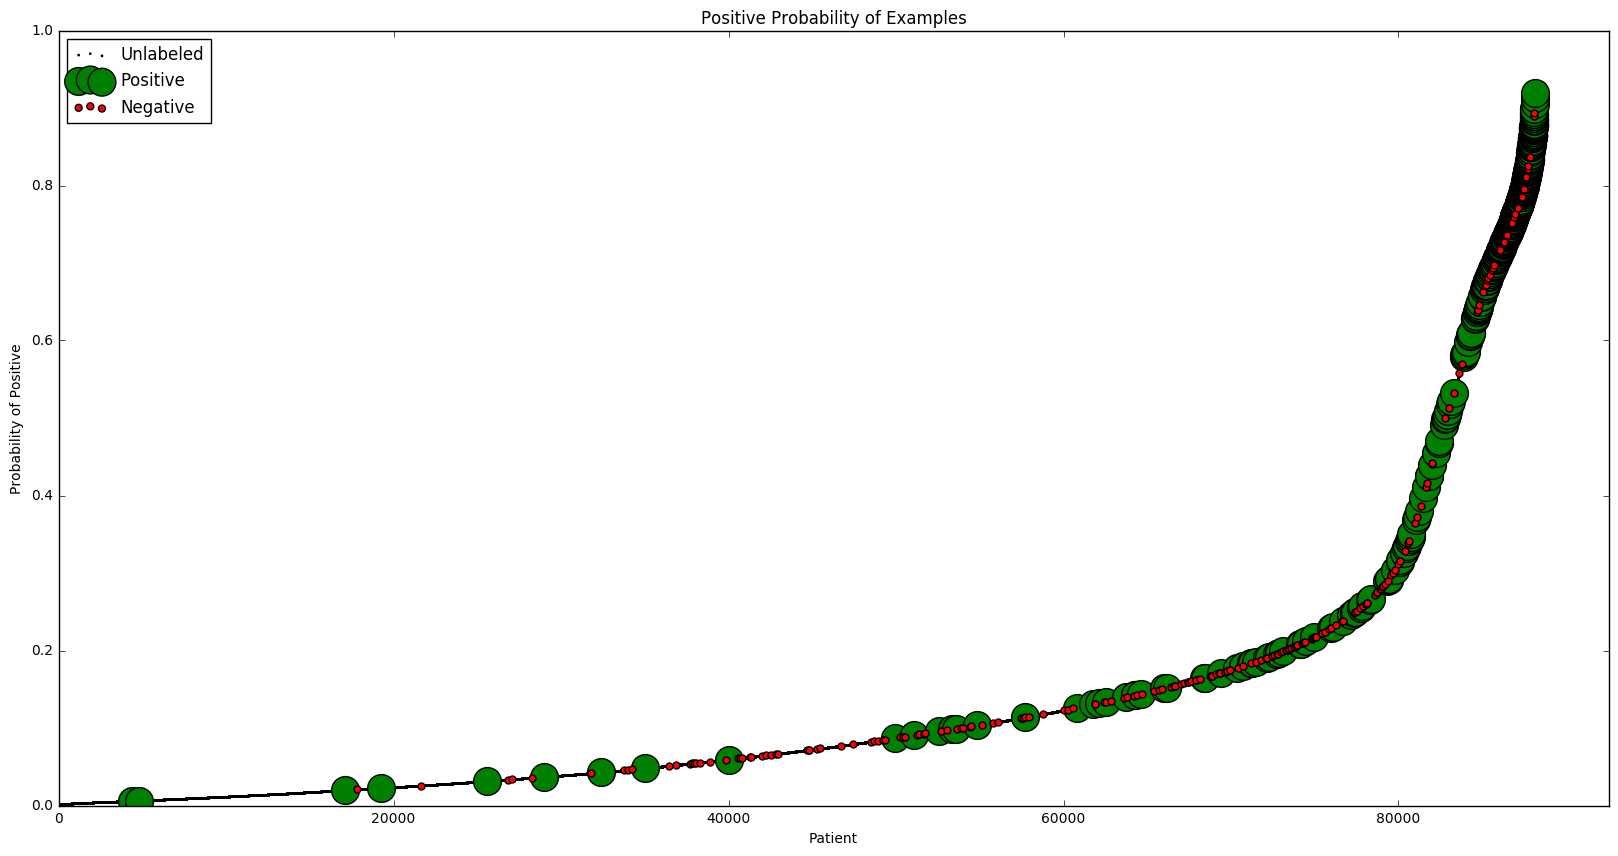

In [28]:
deep.generate_probability_plot()

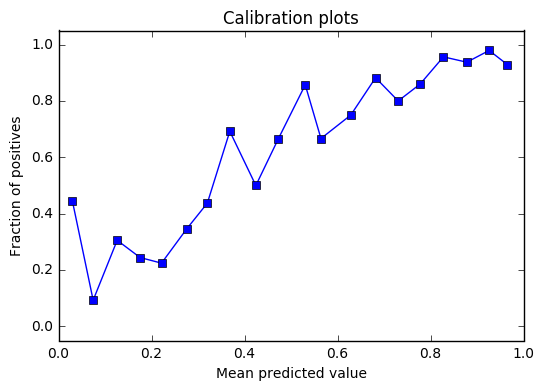

In [29]:
deep.generate_calibration_plot()

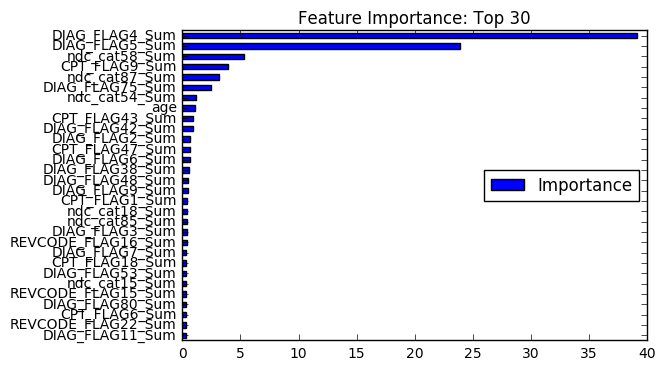

In [30]:
deep.generate_feature_importance_plot(num_features=30)

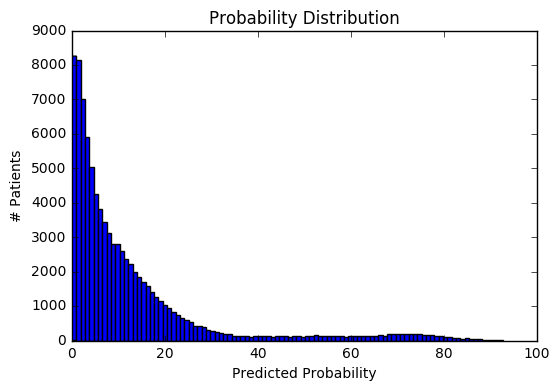

In [31]:
deep.generate_probability_distribution()

In [32]:
deep.generate_percentile_table()

,Unlabeled,Positive,Negative,# Patients,% Unlabeled,% Positive of Labeled,% Negative of Labeled
Predicted Percentile Bucket,,,,,,,
0%-5%,35851.0,8.0,9.0,35868,0.999526,0.470588,0.529412
5%-10%,17975.0,6.0,41.0,18022,0.997392,0.127660,0.872340
10%-15%,11858.0,10.0,27.0,11895,0.996889,0.270270,0.729730
15%-20%,7414.0,15.0,41.0,7470,0.992503,0.267857,0.732143
20%-25%,4143.0,11.0,32.0,4186,0.989728,0.255814,0.744186
25%-30%,2222.0,8.0,18.0,2248,0.988434,0.307692,0.692308
30%-35%,1068.0,10.0,7.0,1085,0.984332,0.588235,0.411765
35%-40%,703.0,5.0,3.0,711,0.988748,0.625000,0.375000
40%-45%,663.0,4.0,4.0,671,0.988077,0.500000,0.500000


# Explore local explanations using LIME

In [ ]:
explanations = deep.generate_explanations(n_examples=1000, random_state=1037, use_decile_samples=True)

In [35]:
deep.save_explanations_to_file('res/explanations.pkl')
#deep.import_explanations_from_file('res/explanations.pkl')

In [36]:
rules_df, features_df = deep.analyze_features()
rules_df_0, features_df_0 = deep.analyze_subgroup(0)
rules_df_5, features_df_5 = deep.analyze_subgroup(5)
rules_df_9, features_df_9 = deep.analyze_subgroup(9)

## Explore most important 'rules' for explanations in the overall population

In [37]:
rules_df.iloc[:20, :]

,N,abs_weight_sum,weight_sum,importance,importance_normal,avg_weight
DIAG_FLAG5_Sum <= 0.00,836,354.119071,-354.119071,18.818052,0.074294,-0.423587
DIAG_FLAG4_Sum <= 0.00,529,202.747005,-202.747005,14.238926,0.056216,-0.383265
DIAG_FLAG4_Sum > 0.00,471,180.570260,180.570260,13.437643,0.053052,0.383376
DIAG_FLAG5_Sum > 0.00,164,69.442441,69.442441,8.333213,0.032900,0.423430
ndc_cat45_Sum <= 0.00,876,40.491899,-40.491899,6.363325,0.025123,-0.046224
DIAG_FLAG6_Sum <= 0.00,925,39.034321,-39.034321,6.247745,0.024666,-0.042199
ndc_cat58_Sum > 1.00,430,28.316153,28.316153,5.321292,0.021009,0.065852
ndc_cat58_Sum <= 0.00,460,23.050275,-23.050275,4.801070,0.018955,-0.050109
DIAG_FLAG80_Sum <= 0.00,812,14.687236,-14.687236,3.832393,0.015130,-0.018088
DIAG_FLAG41_Sum <= 0.00,864,14.489840,-14.489840,3.806552,0.015028,-0.016771


### Most important 'rules' for explanations in the first decile of predicitons [0%-10%) predicted

In [38]:
rules_df_0.iloc[:20, :]

,N,abs_weight_sum,weight_sum,importance,importance_normal,avg_weight
DIAG_FLAG5_Sum <= 0.00,109,46.045205,-46.045205,6.785662,0.093843,-0.422433
DIAG_FLAG4_Sum <= 0.00,109,41.980710,-41.980710,6.479252,0.089606,-0.385144
ndc_cat58_Sum <= 0.00,95,4.792836,-4.792836,2.189255,0.030277,-0.050451
ndc_cat45_Sum <= 0.00,100,4.642810,-4.642810,2.154718,0.029799,-0.046428
DIAG_FLAG6_Sum <= 0.00,107,4.531373,-4.531373,2.128702,0.029439,-0.042349
CPT_FLAG9_Sum <= 0.00,102,2.469363,-2.469363,1.571421,0.021732,-0.024209
DIAG_FLAG41_Sum <= 0.00,101,1.704959,-1.704959,1.305741,0.018058,-0.016881
DIAG_FLAG80_Sum <= 0.00,91,1.612696,-1.612696,1.269920,0.017563,-0.017722
ndc_cat87_Sum <= 0.00,80,1.308416,-1.308416,1.143860,0.015819,-0.016355
DIAG_FLAG75_Sum <= 0.00,86,1.306291,-1.306291,1.142931,0.015806,-0.015189


### fifth percentile [50%-60%)

In [39]:
rules_df_5.iloc[:20, :]

,N,abs_weight_sum,weight_sum,importance,importance_normal,avg_weight
DIAG_FLAG5_Sum <= 0.00,114,47.841565,-47.841565,6.916760,0.092790,-0.419663
DIAG_FLAG4_Sum > 0.00,114,43.570944,43.570944,6.600829,0.088552,0.382201
DIAG_FLAG6_Sum <= 0.00,113,4.755653,-4.755653,2.180746,0.029255,-0.042085
ndc_cat45_Sum <= 0.00,101,4.713236,-4.713236,2.170999,0.029125,-0.046666
ndc_cat58_Sum <= 0.00,71,3.546481,-3.546481,1.883210,0.025264,-0.049950
CPT_FLAG9_Sum > 0.00,80,1.894103,1.894103,1.376264,0.018463,0.023676
DIAG_FLAG80_Sum <= 0.00,100,1.831505,-1.831505,1.353331,0.018155,-0.018315
DIAG_FLAG41_Sum <= 0.00,106,1.813970,-1.813970,1.346837,0.018068,-0.017113
DIAG_FLAG75_Sum > 1.00,96,1.555305,1.555305,1.247119,0.016730,0.016201
ndc_cat58_Sum > 1.00,20,1.330890,1.330890,1.153642,0.015476,0.066544


### tenth percentile [90%-100%)

In [40]:
rules_df_9.iloc[:20, :]

,N,abs_weight_sum,weight_sum,importance,importance_normal,avg_weight
DIAG_FLAG5_Sum > 0.00,20,8.547668,8.547668,2.923640,0.098294,0.427383
DIAG_FLAG4_Sum <= 0.00,12,4.548910,-4.548910,2.132817,0.071707,-0.379076
DIAG_FLAG4_Sum > 0.00,8,3.095513,3.095513,1.759407,0.059152,0.386939
ndc_cat45_Sum <= 0.00,19,0.856275,-0.856275,0.925351,0.031111,-0.045067
DIAG_FLAG6_Sum <= 0.00,20,0.838823,-0.838823,0.915873,0.030792,-0.041941
ndc_cat58_Sum > 1.00,8,0.530107,0.530107,0.728085,0.024479,0.066263
ndc_cat58_Sum <= 0.00,7,0.358366,-0.358366,0.598636,0.020127,-0.051195
CPT_FLAG9_Sum <= 0.00,14,0.344600,-0.344600,0.587026,0.019736,-0.024614
DIAG_FLAG41_Sum <= 0.00,18,0.299881,-0.299881,0.547614,0.018411,-0.016660
DIAG_FLAG80_Sum <= 0.00,14,0.242961,-0.242961,0.492911,0.016572,-0.017354
